In [1]:
import numpy as np
import matplotlib.pyplot as plt

#defenitions

In [2]:
def exp(x, precision = 10e-100):
  S = 0
  q = np.eye(*x.shape, dtype = x.dtype)
  i = 1
  while True:
    S += q
    q = q@x/i
    i+=1
    if np.sum(q**2) < precision**2:
      return S

In [3]:
class solver:
  def __init__(self, x_start = None, w = None, x_dims = 2):
    self.x_start = np.random.uniform(-1, 1, (x_dims, 1)) if x_start is None else np.array(x_start, dtype = np.float64)
    self.w = np.random.uniform(-1, 1, (x_dims, x_dims)) if w is None else np.array(w, dtype = np.float64)

  def numeric(self, t, dt = 0.01):
    x = np.copy(self.x_start)
    N = int(t/dt)
    h = []
    for i in range(N):
      h.append(x[0])
      x += dt * self.w @ x
    return np.array(h)

  def analytical(self, t):
    return exp(t*self.w) @ self.x_start

#test

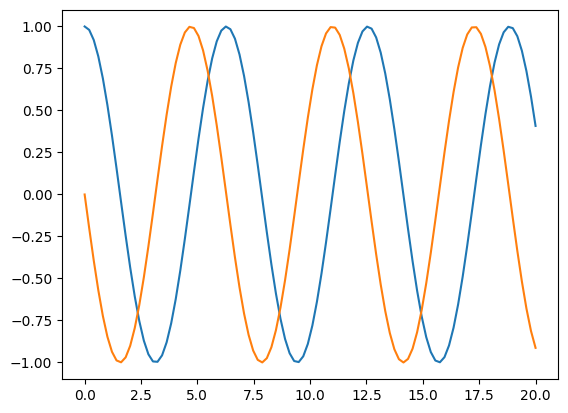

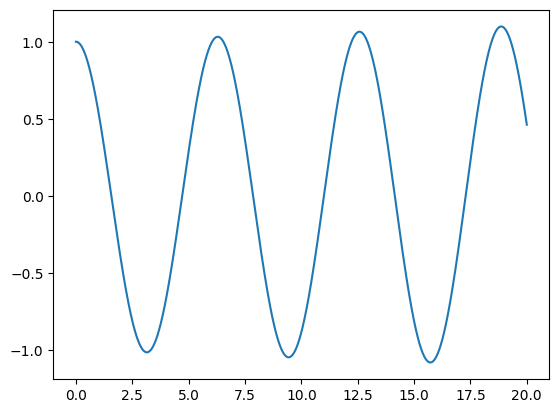

In [4]:
t = np.linspace(0, 20, 100)
s = solver(x_start = [1, 0], w = [
    [0, 1],
    [-1, 0]
    ])
plt.plot(t, [s.analytical(j)[0] for j in t])
plt.plot(t, [s.analytical(j)[1] for j in t])
plt.show()

plt.plot(np.linspace(0, 20, int(20/0.01)), s.numeric(20, dt = 0.01))
plt.show()

In [5]:
class solver2:
  def __init__(self, dt = 0.1, **rules):
    self.rules = rules
    self.params = rules.keys()
    self.dt = dt

  def update(self):
    self.set_to(**{name:getattr(self, name) + self.rules[name](**{name:getattr(self, name) for name in self.rules})*self.dt for name in self.rules})

  def set_to(self, **values):
    for j in values:
      setattr(self, j, values[j])

  def solve(self, t_end, t_start = 0):
    self.t = t_start
    history = {name:[] for name in self.rules}
    history['t'] = []
    while self.t < t_end:
      self.update()
      for j in history:
        history[j].append(getattr(self, j))
      self.t += self.dt
    delattr(self, 't')
    return history

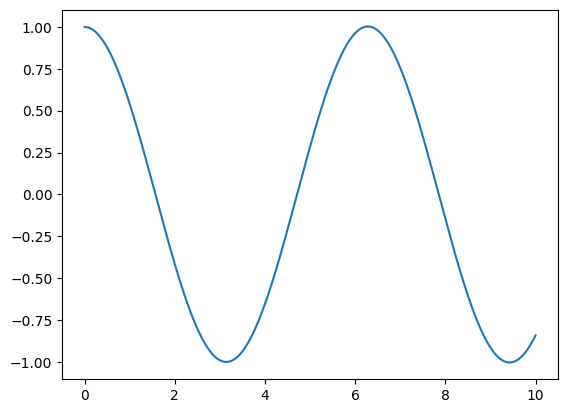

In [ ]:
s = solver2(x = lambda x, y: -y, y = lambda x, y: x, dt = 0.001)
s.x = 1
s.y = 0
n = s.solve(10)
plt.plot(n['t'], n['x'])
plt.show()

In [7]:
def factorial(n):
  if n == 0:
    return 1
  else:
    return n * factorial(n - 1)

def combinations(n, k):
  if k < 0 or k > n:
    return 0
  else:
    return factorial(n) // (factorial(k) * factorial(n - k))

# Differential

In [ ]:
def dirs(x, W, depth):
  dirs = [x]
  for i in range(depth):
    n = len(dirs) - 1
    dirs.append(o := sum(combinations(n, k) * (dirs[k] @ W @ dirs[n - k]) for k in range(0, n + 1)))
  return dirs

def coofs(x, W, depth):
    dirs = [x]
    coeffs = [x]
    for n in range(1, depth):
        dx_dt = np.zeros_like(x)
        for k in range(n):
            binom_coeff = factorial(n - 1) // (factorial(k) * factorial(n - 1 - k))
            dx_dt += binom_coeff * np.einsum("j, ijk, k -> i", dirs[k], W, dirs[n - 1 - k])
        dirs.append(dx_dt)
        coeffs.append(dx_dt / factorial(n))
    return coeffs

def non_linear_solver(x, W, t, depth, C = None):
  if C is None:
    C = coofs(x, W, depth)
  return sum(c*t**n for n, c in enumerate(C))

In [190]:
x_start = np.array([1, 2])
W = np.array([
    [[0, 1],
     [-1, 0]],
    [[1, 1],
     [-1, 0]]
])
non_linear_solver(x_start, W, 9, 10)

array([ 1., 11.])

In [191]:
s2 = solver2(dt = 0.001, x = lambda x: x @ W @ x)
s2.x = x_start
s2.W = W
s2.solve(9)['x'][-1]

array([ 1., 11.])

In [192]:
N = 7
x_start = np.random.uniform(-100, 100, N)
W = np.random.uniform(-10, 10, (N, N, N))

C:\Users\Squmon\AppData\Local\Temp\ipykernel_20620\1577009861.py:15: RuntimeWarning: overflow encountered in multiply
  dx_dt += binom_coeff * np.einsum("j, ijk, k -> i", dirs[k], W, dirs[n - 1 - k])


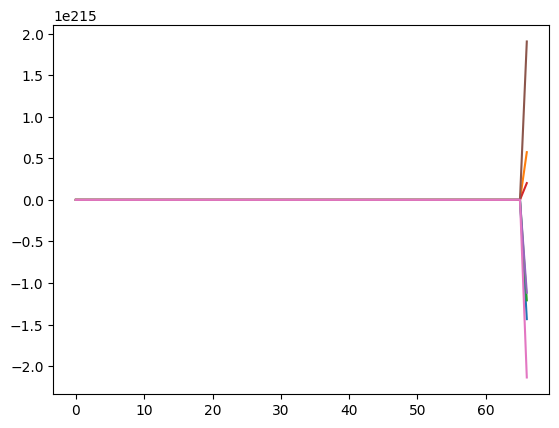

In [193]:
#d = dirs(x_start, W, 50)
#plt.plot([c/factorial(n) for n, c in enumerate(d)])
x_start = np.random.uniform(-100, 100, N)
d = coofs(x_start, W, 80)
plt.plot([c for n, c in enumerate(d)])
plt.show()

C:\Users\Squmon\AppData\Local\Temp\ipykernel_20620\420924535.py:2: RuntimeWarning: overflow encountered in multiply
  plt.plot(T, sum(c[2]*T**i for i, c in enumerate(d)))
C:\Users\Squmon\AppData\Local\Temp\ipykernel_20620\420924535.py:2: RuntimeWarning: invalid value encountered in add
  plt.plot(T, sum(c[2]*T**i for i, c in enumerate(d)))


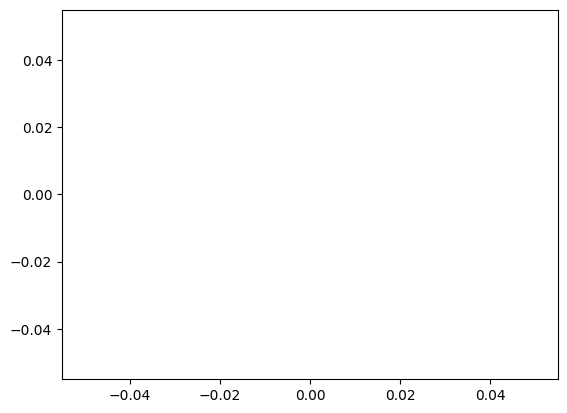

In [194]:
T = np.linspace(0, 100, 100)
plt.plot(T, sum(c[2]*T**i for i, c in enumerate(d)))
plt.show()

In [195]:
x_start = np.array([1, 0, 1])
W = np.array([
    [[0, 0, 0],
     [0, 0, -1],
     [0, 0, 0]],
    [[0, 0, 0],
     [0, 0, 0],
     [1, 0, 0]],
    [[0, 0, 0],
     [0, 0, 0],
     [0, 0, 0]],
])

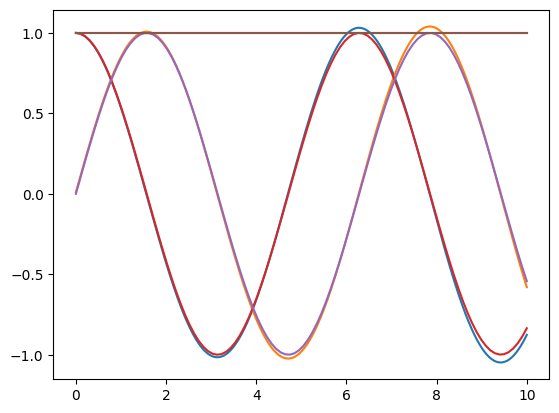

In [200]:
s2 = solver2(dt = 0.01, x = lambda x: np.einsum("j, ijk, k -> i" , x, W, x))
s2.x = x_start
s2.W = W
E = 10
s = s2.solve(E)
T = np.linspace(0, E, 100)
plt.plot(s['t'], np.array(s['x']))
plt.plot(T, [non_linear_solver(x_start, W, t, 30) for t in T])
plt.show()

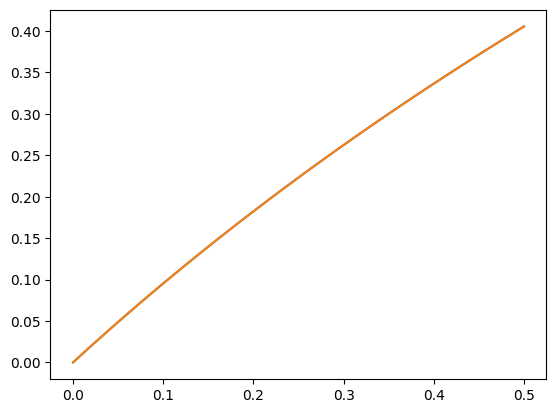

In [262]:
x_start = np.array([0, 1.0, 1, 1])
W = np.zeros((4, 4, 4))

W[0, 1, 3] = 1  # dx/dt = y * b
W[1, 1, 2] = -1 # dy/dt = -y * z
W[2, 2, 2] = -1 # dz/dt = -2 * z * z

s2 = solver2(dt = 0.0001, x = lambda x: np.einsum("j, ijk, k -> i" , x, W, x))
s2.x = x_start
s2.W = W
E = 0.5
s = s2.solve(E)
T = np.linspace(0, E, 100)
plt.plot(s['t'], np.array(s['x'])[:, 0])
plt.plot(T, [non_linear_solver(x_start, W, t, 150)[0] for t in T])
#plt.plot(T, np.log(T + 1))
plt.show()

In [125]:
from math import factorial, exp
import math

def tetration_(x, depth):
    q = x
    p = 1
    for n in range(depth):
        p *= q**(1/factorial(n))
        q = q**x
    return p

def tetration(x, depth):
    q = x
    p = 1
    for n in range(depth):
        p *= q
        q = x*exp(q**(1/(n + 1)))
    return p**(1/depth)

In [162]:
tetration(3, 3)

108.4312877622188

In [160]:
math.e**math.e**math.e

3814279.1047601975

In [151]:
math.e

2.718281828459045